# A3

### Prepare data from(A1)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- Phase 1 & 2: Load and Clean Data (Same as before) ---
# This part remains the same because the pipeline needs the columns to be in a 
# mostly clean, numeric/string format first.
df_raw = pd.read_csv('/ait/ML/car-prediction-final/A3/data/Cars.csv')
df = df_raw.copy()
df = df[~df['fuel'].isin(['CNG', 'LPG'])]
owner_map = {"First Owner": 1, "Second Owner": 2, "Third Owner": 3, "Fourth & Above Owner": 4, "Test Drive Car": 5}
df['owner'] = df['owner'].map(owner_map)
df['mileage'] = pd.to_numeric(df['mileage'].str.split().str[0], errors='coerce')
df['engine'] = pd.to_numeric(df['engine'].str.split().str[0], errors='coerce')
df['max_power'] = pd.to_numeric(df['max_power'].str.split().str[0], errors='coerce')
df['brand'] = df['name'].str.split().str[0]
df = df.drop(columns=['torque'])
df = df[df['owner'] != 5]
df = df.reset_index(drop=True)

print("✅ Phase 1 & 2: Initial data cleaning complete.")


# --- Phase 3: Prepare Data with the ColumnTransformer Pipeline ---

# Step 3.1: Create the target variable
# Using 'duplicates=drop' to handle potential issues with qcut if bin edges are not unique
df['price_category'] = pd.qcut(df['selling_price'], q=4, labels=False, duplicates='drop')

# Step 3.2: Define all features that the pipeline will use
# These MUST match the columns listed in your preproc object
cat_features = ["fuel", "seller_type", "transmission", "brand"]
num_features = ["engine", "max_power", "mileage", "seats", "year", "km_driven", "owner"]
all_features = cat_features + num_features

X = df[all_features]
y = df['price_category']

# Step 3.3: Split data into training and testing sets FIRST
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"✅ Data split complete. X_train shape: {X_train.shape}")

# Step 3.4: Define and Fit the Preprocessing Pipeline
# This is the exact ColumnTransformer you provided
preproc = ColumnTransformer([
    ("cat", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) # sparse_output=False is easier to inspect
    ]), cat_features),
    ("num_median", Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ]), ["engine", "max_power"]),
    ("num_mean", Pipeline([
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler())
    ]), ["mileage"]),
    ("num_mode", Pipeline([
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("scale", StandardScaler())
    ]), ["seats"]),
    ("num_pass", Pipeline([
        ("scale", StandardScaler())
    ]), ["year", "km_driven", "owner"]),
], remainder='passthrough') # 'passthrough' is good practice

# FIT the pipeline ONLY on the training data
preproc.fit(X_train)
print("✅ Pipeline fitted successfully on X_train.")

# TRANSFORM both the training and test data
X_train_processed = preproc.transform(X_train)
X_test_processed = preproc.transform(X_test)
print("✅ X_train and X_test transformed.")

# Let's check the result
print(f"\nOriginal number of features: {X_train.shape[1]}")
print(f"Shape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed test data:  {X_test_processed.shape}")

✅ Phase 1 & 2: Initial data cleaning complete.
✅ Data split complete. X_train shape: (6422, 11)
✅ Pipeline fitted successfully on X_train.
✅ X_train and X_test transformed.

Original number of features: 11
Shape of processed training data: (6422, 45)
Shape of processed test data:  (1606, 45)


### Task 1

In [2]:
import numpy as np
from sklearn.metrics import classification_report

def calculate_full_classification_report(y_true, y_pred):
    """
    Calculates and prints a full classification report including
    per-class, macro avg, and weighted avg metrics.
    """
    print("--- From-Scratch Classification Report ---")
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    classes = sorted(np.unique(y_true))
    
    # --- Per-class metrics ---
    per_class_precision = []
    per_class_recall = []
    per_class_f1 = []
    per_class_support = []

    for c in classes:
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        support = np.sum(y_true == c)
        
        per_class_precision.append(precision)
        per_class_recall.append(recall)
        per_class_f1.append(f1)
        per_class_support.append(support)
        
        print(f"Class {c}: P={precision:.2f}, R={recall:.2f}, F1={f1:.2f}, Support={support}")

    # --- Averages ---
    total_samples = np.sum(per_class_support)
    
    # Macro averages (simple mean)
    macro_avg_p = np.mean(per_class_precision)
    macro_avg_r = np.mean(per_class_recall)
    macro_avg_f1 = np.mean(per_class_f1)
    
    # Weighted averages
    weighted_avg_p = np.sum(np.array(per_class_precision) * np.array(per_class_support)) / total_samples
    weighted_avg_r = np.sum(np.array(per_class_recall) * np.array(per_class_support)) / total_samples
    weighted_avg_f1 = np.sum(np.array(per_class_f1) * np.array(per_class_support)) / total_samples
    
    # Overall accuracy
    accuracy = np.sum(y_true == y_pred) / total_samples

    print("-" * 40)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Avg: P={macro_avg_p:.2f}, R={macro_avg_r:.2f}, F1={macro_avg_f1:.2f}")
    print(f"Weighted Avg: P={weighted_avg_p:.2f}, R={weighted_avg_r:.2f}, F1={weighted_avg_f1:.2f}")
    print("-" * 40)


In [3]:
import numpy as np

class LogisticRegression:
    """
    A from-scratch implementation of Multinomial Logistic Regression 
    using batch gradient descent.
    """
    def __init__(self, learning_rate=0.1, n_iterations=1000):
        # Step 1: Initialize hyperparameters
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _one_hot(self, y, n_classes):
        # Step 2: Convert target labels to one-hot encoding
        # e.g., for 4 classes, label '2' becomes [0, 0, 1, 0]
        ohe = np.zeros((len(y), n_classes))
        ohe[np.arange(len(y)), y] = 1
        return ohe

    def softmax(self, z):
        # Step 3: Implement the softmax function
        # The subtraction of max(z) is a trick for numerical stability
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        # Step 4: The training method (Gradient Descent)
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Initialize weights and bias to zeros
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)
        
        # Convert y to one-hot format for loss calculation
        y_ohe = self._one_hot(y, n_classes)
        
        # Main training loop
        for i in range(self.n_iterations):
            # 1. Calculate raw model scores (logits)
            z = X @ self.weights + self.bias
            
            # 2. Convert scores to probabilities (forward pass)
            y_hat = self.softmax(z)
            
            # 3. Calculate the gradient
            # This is the key formula from the lecture/notebook
            gradient = (1 / n_samples) * (X.T @ (y_hat - y_ohe))
            
            # 4. Update the weights
            self.weights -= self.learning_rate * gradient
            
            # (Optional) We could add a step to calculate and store the loss here
            if (i % 100 == 0):
                loss = -np.mean(np.sum(y_ohe * np.log(y_hat + 1e-8), axis=1))
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def predict(self, X):
        # Step 5: The prediction method
        z = X @ self.weights + self.bias
        y_hat = self.softmax(z)
        
        # Return the class with the highest probability
        return np.argmax(y_hat, axis=1)


# --- How to use it with our data ---

# 1. Instantiate the model
# Remember X_train_processed and y_train from our data prep step
model = LogisticRegression(learning_rate=0.1, n_iterations=500)

# 2. Train the model
# NOTE: The 'y_train' must be a NumPy array for this to work correctly
model.fit(X_train_processed, y_train.to_numpy())

# 3. Make predictions on the test set
predictions = model.predict(X_test_processed)

# 4. Evaluate the predictions
# We can use the metrics function we wrote earlier!
print("\n--- Evaluating our from-scratch model ---")
calculate_full_classification_report(y_test.to_numpy(), predictions)

Iteration 0, Loss: 1.3863
Iteration 100, Loss: 0.8513
Iteration 200, Loss: 0.7798
Iteration 300, Loss: 0.7426
Iteration 400, Loss: 0.7184

--- Evaluating our from-scratch model ---
--- From-Scratch Classification Report ---
Class 0: P=0.86, R=0.85, F1=0.85, Support=410
Class 1: P=0.64, R=0.67, F1=0.65, Support=409
Class 2: P=0.60, R=0.57, F1=0.58, Support=389
Class 3: P=0.77, R=0.78, F1=0.78, Support=398
----------------------------------------
Accuracy: 0.7192
Macro Avg: P=0.72, R=0.72, F1=0.72
Weighted Avg: P=0.72, R=0.72, F1=0.72
----------------------------------------


In [4]:
# --- Mockup Data Example ---
y_true_mock = [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 0]
y_pred_mock = [0, 2, 2, 3, 0, 1, 1, 3, 0, 0, 0]

# 1. Run your from-scratch function
print("--- My From-Scratch Report ---")
calculate_full_classification_report(y_true_mock, y_pred_mock)

print("\n" + "="*50 + "\n") # Separator

# 2. Run the scikit-learn function for comparison
from sklearn.metrics import classification_report
print("--- Scikit-learn's Report ---")
print(classification_report(y_true_mock, y_pred_mock))

--- My From-Scratch Report ---
--- From-Scratch Classification Report ---
Class 0: P=0.80, R=1.00, F1=0.89, Support=4
Class 1: P=0.50, R=0.33, F1=0.40, Support=3
Class 2: P=0.50, R=0.50, F1=0.50, Support=2
Class 3: P=1.00, R=1.00, F1=1.00, Support=2
----------------------------------------
Accuracy: 0.7273
Macro Avg: P=0.70, R=0.71, F1=0.70
Weighted Avg: P=0.70, R=0.73, F1=0.71
----------------------------------------


--- Scikit-learn's Report ---
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.50      0.33      0.40         3
           2       0.50      0.50      0.50         2
           3       1.00      1.00      1.00         2

    accuracy                           0.73        11
   macro avg       0.70      0.71      0.70        11
weighted avg       0.70      0.73      0.71        11



#### Task 1: Validation and Conceptual Questions

#### Comparison with Scikit-learn

To validate our from-scratch metrics function, we compare its output directly against the standard `sklearn.metrics.classification_report`. We use the same set of mockup true labels and predictions for both functions to ensure a fair comparison.

**Analysis:**
The output from the code cell above shows that the calculated values for per-class **precision**, **recall**, **f1-score**, as well as the **macro average** and **weighted average** from our custom `calculate_full_classification_report` function are identical to those produced by scikit-learn. This comparison validates the correctness of our from-scratch implementation.

---

#### Definition of "Support"

In the context of a classification report, **support** refers to the **number of actual occurrences of a class in the true dataset** (`y_true`).

It is a crucial metric because it provides context for the performance scores. A high F1-score is more reliable for a class with a large support (many samples) than for a class with very small support. It helps us understand the trustworthiness of the metrics for each class and is a quick way to identify class imbalance.

In [5]:
import numpy as np
import math
import matplotlib.pyplot as plt

class LogisticRegression:
    """
    A from-scratch implementation of Multinomial Logistic Regression.
    
    Features:
    - L2 (Ridge) Regularization
    - Batch, Mini-Batch, and Stochastic Gradient Descent
    - Loss history tracking for diagnostics
    """
    def __init__(self, learning_rate=0.1, n_iterations=100, lmbda=0.01, batch_size=32):
        """
        Initializes the model.
        
        Args:
            learning_rate (float): Step size for gradient descent.
            n_iterations (int): Number of epochs (full passes over the training data).
            lmbda (float): Regularization strength (lambda).
            batch_size (int): Number of samples per batch.
                - If batch_size == n_samples -> Batch Gradient Descent
                - If batch_size == 1 -> Stochastic Gradient Descent (SGD)
                - Otherwise -> Mini-Batch Gradient Descent
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.lmbda = lmbda
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _one_hot(self, y, n_classes):
        """Helper function to convert labels to one-hot encoding."""
        ohe = np.zeros((len(y), n_classes))
        ohe[np.arange(len(y)), y] = 1
        return ohe

    def softmax(self, z):
        """The softmax activation function for converting scores to probabilities."""
        # Subtracting max(z) is a trick for numerical stability to prevent overflow
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        """Trains the model using the provided data."""
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Initialize weights and bias to zeros
        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)
        
        # The main loop now iterates over epochs
        for epoch in range(self.n_iterations):
            # --- CRITICAL STEP: Shuffle the data at the start of each epoch ---
            permutation = np.random.permutation(n_samples)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            # --- Loop over mini-batches ---
            n_batches = math.ceil(n_samples / self.batch_size)
            for i in range(n_batches):
                # Get the current mini-batch
                start = i * self.batch_size
                end = min(start + self.batch_size, n_samples)
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                # --- The logic below uses the BATCH data for one update ---
                n_batch_samples = X_batch.shape[0]
                if n_batch_samples == 0: continue
                
                y_ohe_batch = self._one_hot(y_batch, n_classes)

                # 1. Calculate scores (logits) and probabilities
                z = X_batch @ self.weights + self.bias
                y_hat = self.softmax(z)
                
                # 2. Calculate gradient with L2 penalty
                original_gradient = (1 / n_batch_samples) * (X_batch.T @ (y_hat - y_ohe_batch))
                l2_penalty = (self.lmbda / n_batch_samples) * self.weights
                gradient = original_gradient + l2_penalty
                
                # 3. Update weights
                self.weights -= self.learning_rate * gradient

            # --- Calculate and store loss on the FULL dataset at the end of each epoch ---
            full_z = X @ self.weights + self.bias
            full_y_hat = self.softmax(full_z)
            full_y_ohe = self._one_hot(y, n_classes)
            
            cross_entropy_loss = -np.mean(np.sum(full_y_ohe * np.log(full_y_hat + 1e-8), axis=1))
            l2_loss_penalty = (self.lmbda / (2 * n_samples)) * np.sum(self.weights**2)
            total_loss = cross_entropy_loss + l2_loss_penalty
            self.loss_history.append(total_loss)
            
            if (epoch % 10 == 0) or (epoch == self.n_iterations - 1):
                print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    def predict(self, X):
        """Makes predictions for new data."""
        z = X @ self.weights + self.bias
        y_hat = self.softmax(z)
        return np.argmax(y_hat, axis=1)

Epoch 0, Loss: 0.8512
Epoch 10, Loss: 0.6495
Epoch 20, Loss: 0.6198
Epoch 30, Loss: 0.6060
Epoch 40, Loss: 0.5984
Epoch 50, Loss: 0.5942


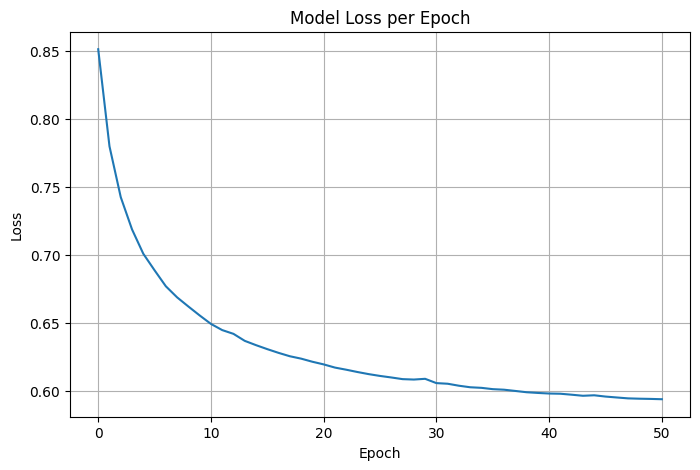


--- Final Model Performance ---
--- From-Scratch Classification Report ---
Class 0: P=0.89, R=0.84, F1=0.86, Support=410
Class 1: P=0.68, R=0.74, F1=0.71, Support=409
Class 2: P=0.65, R=0.64, F1=0.64, Support=389
Class 3: P=0.83, R=0.82, F1=0.82, Support=398
----------------------------------------
Accuracy: 0.7603
Macro Avg: P=0.76, R=0.76, F1=0.76
Weighted Avg: P=0.76, R=0.76, F1=0.76
----------------------------------------


In [6]:
# 1. Instantiate the model with desired hyperparameters
model = LogisticRegression(
    learning_rate=0.1, 
    n_iterations=51,  # Number of epochs
    lmbda=0.01,       # Regularization strength
    batch_size=64     # Mini-batch size
)

# 2. Train the model (it will print the loss at the end of each epoch)
# Note: y_train must be a NumPy array
model.fit(X_train_processed, y_train.to_numpy())

# 3. Plot the loss history to diagnose training
plt.figure(figsize=(8, 5))
plt.plot(model.loss_history)
plt.title("Model Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 4. Make predictions and evaluate
predictions = model.predict(X_test_processed)
print("\n--- Final Model Performance ---")
calculate_full_classification_report(y_test.to_numpy(), predictions)

In [7]:
from sklearn.metrics import f1_score
import time
import random

# 1. Define the same expanded grid of possibilities
param_grid_expanded = {
    'learning_rate': [0.1, 0.05, 0.01],
    'lmbda': [0.001, 0.01, 0.1, 1.0],
    'batch_size': [32, 64]
}

# 2. Set the number of random combinations you want to try
# We'll try 8 random models instead of all 24.
n_iter = 8

# 3. Prepare to track the best results
best_score = -1
best_params = {}
results = []

print(f"--- Starting Random Search (testing {n_iter} random combinations) ---")
start_time = time.time()

# 4. Loop for a fixed number of iterations
for i in range(n_iter):
    
    # --- Pick a RANDOM value for each hyperparameter ---
    lr = random.choice(param_grid_expanded['learning_rate'])
    lmbda = random.choice(param_grid_expanded['lmbda'])
    bs = random.choice(param_grid_expanded['batch_size'])
    
    current_params = {'lr': lr, 'lmbda': lmbda, 'batch_size': bs}
    print(f"\n({i+1}/{n_iter}) Training with random params: {current_params}")
    
    # Instantiate and train the model
    model = LogisticRegression(
        learning_rate=lr,
        n_iterations=101,
        lmbda=lmbda,
        batch_size=bs
    )
    model.fit(X_train_processed, y_train.to_numpy())
    
    # Evaluate the model
    predictions = model.predict(X_test_processed)
    score = f1_score(y_test, predictions, average='weighted')
    
    print(f"-> Weighted F1-Score: {score:.4f}")
    results.append({'params': current_params, 'score': score})
    
    # Check if this is the best model so far
    if score > best_score:
        best_score = score
        best_params = current_params

end_time = time.time()
print(f"\n--- Random Search Complete in {end_time - start_time:.2f} seconds ---")
print(f"🏆 Best Weighted F1-Score: {best_score:.4f}")
print(f"🚀 Best Hyperparameters: {best_params}")

--- Starting Random Search (testing 8 random combinations) ---

(1/8) Training with random params: {'lr': 0.05, 'lmbda': 1.0, 'batch_size': 64}
Epoch 0, Loss: 0.9394
Epoch 10, Loss: 0.7512
Epoch 20, Loss: 0.7376
Epoch 30, Loss: 0.7349
Epoch 40, Loss: 0.7341
Epoch 50, Loss: 0.7341
Epoch 60, Loss: 0.7341
Epoch 70, Loss: 0.7337
Epoch 80, Loss: 0.7338
Epoch 90, Loss: 0.7343
Epoch 100, Loss: 0.7337
-> Weighted F1-Score: 0.7160

(2/8) Training with random params: {'lr': 0.1, 'lmbda': 1.0, 'batch_size': 32}
Epoch 0, Loss: 0.8316
Epoch 10, Loss: 0.7943
Epoch 20, Loss: 0.7934
Epoch 30, Loss: 0.7932
Epoch 40, Loss: 0.7957
Epoch 50, Loss: 0.7932
Epoch 60, Loss: 0.7931
Epoch 70, Loss: 0.7933
Epoch 80, Loss: 0.7938
Epoch 90, Loss: 0.7967
Epoch 100, Loss: 0.7943
-> Weighted F1-Score: 0.6673

(3/8) Training with random params: {'lr': 0.1, 'lmbda': 0.1, 'batch_size': 32}
Epoch 0, Loss: 0.7863
Epoch 10, Loss: 0.6455
Epoch 20, Loss: 0.6365
Epoch 30, Loss: 0.6334
Epoch 40, Loss: 0.6348
Epoch 50, Loss: 0.

#### MLFLOW 

In [8]:
import os
import mlflow
import random
import time
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score
from sklearn.base import BaseEstimator, ClassifierMixin


# --- Make sure your LogisticRegression class is in a file named 'model.py' ---
# If you get an ImportError, it means the file is not in the same directory.
try:
    from model import LogisticRegression
except ImportError:
    print("❌ Error: 'model.py' not found. Please ensure it's in the same directory.")
    # You can define a dummy class to prevent the script from crashing immediately
    class LogisticRegression: pass 

# --- A wrapper to make our from-scratch model compatible with mlflow.sklearn ---
class SklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.1, n_iterations=100, lmbda=0.01, batch_size=32):
        # We instantiate our actual model inside the wrapper
        self.model = LogisticRegression(learning_rate, n_iterations, lmbda, batch_size)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)


# --- 1. SET CREDENTIALS AND CONFIGURE MLFLOW (same as before) ---
os.environ['MLFLOW_TRACKING_USERNAME'] = 'admin' 
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'password'
mlflow.set_tracking_uri("http://mlflow.ml.brain.cs.ait.ac.th/")
mlflow.set_experiment("st126055-a3") 

# --- 2. DEFINE YOUR FULL HYPERPARAMETER GRID ---
param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'lmbda': [0.001, 0.01, 0.1, 1.0],
    'batch_size': [1, 32, 64, 128]
}

total_runs = len(param_grid['learning_rate']) * len(param_grid['lmbda']) * len(param_grid['batch_size'])
print(f"--- Starting GRID Search: Logging all {total_runs} runs to MLflow ---")
start_time = time.time()
run_count = 0

# --- USE NESTED LOOPS FOR GRID SEARCH ---
for lr in param_grid['learning_rate']:
    for lmbda in param_grid['lmbda']:
        for bs in param_grid['batch_size']:
            run_count += 1
            current_params = {'learning_rate': lr, 'lmbda': lmbda, 'batch_size': bs}
            run_name = f"run_{run_count}_lr={lr}_lambda={lmbda}_bs={bs}"
            
            with mlflow.start_run(run_name=run_name):
                print(f"\n({run_count}/{total_runs}) Logging run: '{run_name}'")
                mlflow.log_params(current_params)
                
                # Train the model
                wrapped_model = SklearnWrapper(
                    learning_rate=lr,
                    n_iterations=101,
                    lmbda=lmbda,
                    batch_size=bs
                )
                wrapped_model.fit(X_train_processed, y_train.to_numpy())
                
                # --- LOG THE LOSS CURVE (already implemented) ---
                for epoch, loss in enumerate(wrapped_model.model.loss_history):
                    mlflow.log_metric("epoch_loss", loss, step=epoch)
                
                # --- CALCULATE AND LOG ALL FINAL METRICS ---
                predictions = wrapped_model.predict(X_test_processed)
                
                # Calculate all the scores
                accuracy = accuracy_score(y_test, predictions)
                precision = precision_score(y_test, predictions, average='weighted')
                recall = recall_score(y_test, predictions, average='weighted')
                f1 = f1_score(y_test, predictions, average='weighted')
                
                print(f"-> Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
                
                # Log each metric to MLflow
                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision_weighted", precision)
                mlflow.log_metric("recall_weighted", recall)
                mlflow.log_metric("f1_score_weighted", f1)
                
                # LOG MODEL (same as before)
                mlflow.sklearn.log_model(wrapped_model, artifact_path="model")

end_time = time.time()
print(f"\n--- Grid Search finished in {end_time - start_time:.2f} seconds ---")

--- Starting GRID Search: Logging all 48 runs to MLflow ---

(1/48) Logging run: 'run_1_lr=0.1_lambda=0.001_bs=1'
-> Accuracy: 0.6743, Precision: 0.7339, Recall: 0.6743, F1: 0.6720


2025/10/04 12:24:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:24:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_1_lr=0.1_lambda=0.001_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/fb73c90657334c509e7c2e3371fd3a3e
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(2/48) Logging run: 'run_2_lr=0.1_lambda=0.001_bs=32'
-> Accuracy: 0.7497, Precision: 0.7546, Recall: 0.7497, F1: 0.7517


2025/10/04 12:25:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:25:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_2_lr=0.1_lambda=0.001_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/8d6c54097a6e4c359dc3e0f15ede8b32
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(3/48) Logging run: 'run_3_lr=0.1_lambda=0.001_bs=64'
-> Accuracy: 0.7603, Precision: 0.7648, Recall: 0.7603, F1: 0.7620


2025/10/04 12:26:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:26:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_3_lr=0.1_lambda=0.001_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/4a0beefd5ee64c468b4de4c6ee2c5bd8
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(4/48) Logging run: 'run_4_lr=0.1_lambda=0.001_bs=128'
-> Accuracy: 0.7584, Precision: 0.7620, Recall: 0.7584, F1: 0.7599


2025/10/04 12:27:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:27:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_4_lr=0.1_lambda=0.001_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/a8af9fecdef64b5d8e3a48eda230b8b5
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(5/48) Logging run: 'run_5_lr=0.1_lambda=0.01_bs=1'
-> Accuracy: 0.6488, Precision: 0.6641, Recall: 0.6488, F1: 0.6514


2025/10/04 12:28:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:29:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_5_lr=0.1_lambda=0.01_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/f4edfd7d981c408bb4bf1990e13a862c
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(6/48) Logging run: 'run_6_lr=0.1_lambda=0.01_bs=32'
-> Accuracy: 0.7628, Precision: 0.7640, Recall: 0.7628, F1: 0.7627


2025/10/04 12:30:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:30:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_6_lr=0.1_lambda=0.01_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/525929b151244cfbaf3e30492321e5e6
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(7/48) Logging run: 'run_7_lr=0.1_lambda=0.01_bs=64'
-> Accuracy: 0.7603, Precision: 0.7630, Recall: 0.7603, F1: 0.7614


2025/10/04 12:31:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:31:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_7_lr=0.1_lambda=0.01_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/33c693224aeb47f793e4549b5409cb31
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(8/48) Logging run: 'run_8_lr=0.1_lambda=0.01_bs=128'
-> Accuracy: 0.7534, Precision: 0.7570, Recall: 0.7534, F1: 0.7550


2025/10/04 12:32:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:32:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_8_lr=0.1_lambda=0.01_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/dd50d64fe7af42208b4a0c0db619a471
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(9/48) Logging run: 'run_9_lr=0.1_lambda=0.1_bs=1'
-> Accuracy: 0.5262, Precision: 0.5506, Recall: 0.5262, F1: 0.5010


2025/10/04 12:33:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:33:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_9_lr=0.1_lambda=0.1_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/d6870d596fc64fa496cff1c55b46aa34
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(10/48) Logging run: 'run_10_lr=0.1_lambda=0.1_bs=32'
-> Accuracy: 0.7447, Precision: 0.7467, Recall: 0.7447, F1: 0.7456


2025/10/04 12:35:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:35:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_10_lr=0.1_lambda=0.1_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/a98452e482944831a2dd21e63776faf1
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(11/48) Logging run: 'run_11_lr=0.1_lambda=0.1_bs=64'
-> Accuracy: 0.7528, Precision: 0.7573, Recall: 0.7528, F1: 0.7547


2025/10/04 12:36:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:36:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_11_lr=0.1_lambda=0.1_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/ecb385c4b8ba4395a2f35ff8c151fb4b
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(12/48) Logging run: 'run_12_lr=0.1_lambda=0.1_bs=128'
-> Accuracy: 0.7565, Precision: 0.7588, Recall: 0.7565, F1: 0.7575


2025/10/04 12:37:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:37:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_12_lr=0.1_lambda=0.1_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/b4fad985d1ea467c9e5124b061688523
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(13/48) Logging run: 'run_13_lr=0.1_lambda=1.0_bs=1'
-> Accuracy: 0.4888, Precision: 0.3878, Recall: 0.4888, F1: 0.4114


2025/10/04 12:38:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:38:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_13_lr=0.1_lambda=1.0_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/62488f3da83245e8a6cd2eeff7af199b
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(14/48) Logging run: 'run_14_lr=0.1_lambda=1.0_bs=32'
-> Accuracy: 0.7080, Precision: 0.7109, Recall: 0.7080, F1: 0.7085


2025/10/04 12:40:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:40:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_14_lr=0.1_lambda=1.0_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/47bd1aeb63a7468db28e72ac543adaee
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(15/48) Logging run: 'run_15_lr=0.1_lambda=1.0_bs=64'
-> Accuracy: 0.7260, Precision: 0.7375, Recall: 0.7260, F1: 0.7282


2025/10/04 12:41:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:41:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_15_lr=0.1_lambda=1.0_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/1b9eea2fa7a942e6a331a76a3661ae88
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(16/48) Logging run: 'run_16_lr=0.1_lambda=1.0_bs=128'
-> Accuracy: 0.7416, Precision: 0.7482, Recall: 0.7416, F1: 0.7434


2025/10/04 12:42:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:42:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_16_lr=0.1_lambda=1.0_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/bcb710ccdad14255957ae7987758abc0
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(17/48) Logging run: 'run_17_lr=0.05_lambda=0.001_bs=1'
-> Accuracy: 0.7167, Precision: 0.7317, Recall: 0.7167, F1: 0.7148


2025/10/04 12:43:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:43:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_17_lr=0.05_lambda=0.001_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/2f561a43b8774890a745d3eff30e8ec1
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(18/48) Logging run: 'run_18_lr=0.05_lambda=0.001_bs=32'
-> Accuracy: 0.7503, Precision: 0.7547, Recall: 0.7503, F1: 0.7521


2025/10/04 12:45:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:45:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_18_lr=0.05_lambda=0.001_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/91edb4232a7a4ffd84890082a654a956
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(19/48) Logging run: 'run_19_lr=0.05_lambda=0.001_bs=64'
-> Accuracy: 0.7559, Precision: 0.7597, Recall: 0.7559, F1: 0.7575


2025/10/04 12:46:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:46:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_19_lr=0.05_lambda=0.001_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/fd201e3db9824d3185e705f625075dc7
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(20/48) Logging run: 'run_20_lr=0.05_lambda=0.001_bs=128'
-> Accuracy: 0.7478, Precision: 0.7528, Recall: 0.7478, F1: 0.7498


2025/10/04 12:47:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:47:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_20_lr=0.05_lambda=0.001_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/99449bc467534effb43fc53457569fe0
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(21/48) Logging run: 'run_21_lr=0.05_lambda=0.01_bs=1'
-> Accuracy: 0.6694, Precision: 0.6707, Recall: 0.6694, F1: 0.6515


2025/10/04 12:49:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:49:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_21_lr=0.05_lambda=0.01_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/584fb885c2f942cda85cdae311924853
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(22/48) Logging run: 'run_22_lr=0.05_lambda=0.01_bs=32'
-> Accuracy: 0.7522, Precision: 0.7547, Recall: 0.7522, F1: 0.7529


2025/10/04 12:50:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:50:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_22_lr=0.05_lambda=0.01_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/df477fa9aa6444b79ebcac8ed3b355bf
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(23/48) Logging run: 'run_23_lr=0.05_lambda=0.01_bs=64'
-> Accuracy: 0.7540, Precision: 0.7579, Recall: 0.7540, F1: 0.7557


2025/10/04 12:51:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:51:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_23_lr=0.05_lambda=0.01_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/8749773639d54de4b36109616f9bc72d
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(24/48) Logging run: 'run_24_lr=0.05_lambda=0.01_bs=128'
-> Accuracy: 0.7565, Precision: 0.7600, Recall: 0.7565, F1: 0.7580


2025/10/04 12:52:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:52:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_24_lr=0.05_lambda=0.01_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/4fece43f856a4530a38e956d1e77f7f9
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(25/48) Logging run: 'run_25_lr=0.05_lambda=0.1_bs=1'
-> Accuracy: 0.5934, Precision: 0.5835, Recall: 0.5934, F1: 0.5796


2025/10/04 12:54:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:54:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_25_lr=0.05_lambda=0.1_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/f336c8a4f20b4a64836484c8b7fc6086
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(26/48) Logging run: 'run_26_lr=0.05_lambda=0.1_bs=32'
-> Accuracy: 0.7491, Precision: 0.7515, Recall: 0.7491, F1: 0.7501


2025/10/04 12:55:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:55:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_26_lr=0.05_lambda=0.1_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/eae5fa0373054cd8949248c21177e1f9
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(27/48) Logging run: 'run_27_lr=0.05_lambda=0.1_bs=64'
-> Accuracy: 0.7578, Precision: 0.7610, Recall: 0.7578, F1: 0.7590


2025/10/04 12:56:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:56:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_27_lr=0.05_lambda=0.1_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/fb395bde11724062bccd691a130b15b3
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(28/48) Logging run: 'run_28_lr=0.05_lambda=0.1_bs=128'
-> Accuracy: 0.7565, Precision: 0.7605, Recall: 0.7565, F1: 0.7580


2025/10/04 12:57:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:57:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_28_lr=0.05_lambda=0.1_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/84d80f61092f4d198057f70f66d3aba9
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(29/48) Logging run: 'run_29_lr=0.05_lambda=1.0_bs=1'
-> Accuracy: 0.5274, Precision: 0.5071, Recall: 0.5274, F1: 0.4765


2025/10/04 12:59:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 12:59:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_29_lr=0.05_lambda=1.0_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/e7a3a1ab57db440b87e19c082e0fdf11
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(30/48) Logging run: 'run_30_lr=0.05_lambda=1.0_bs=32'
-> Accuracy: 0.7142, Precision: 0.7128, Recall: 0.7142, F1: 0.7135


2025/10/04 13:00:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:00:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_30_lr=0.05_lambda=1.0_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/6ea4a8f694b24309972f80d4668a9d0f
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(31/48) Logging run: 'run_31_lr=0.05_lambda=1.0_bs=64'
-> Accuracy: 0.7360, Precision: 0.7399, Recall: 0.7360, F1: 0.7366


2025/10/04 13:01:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:01:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_31_lr=0.05_lambda=1.0_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/e6645b4c65da4601a7492397ff5d04d8
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(32/48) Logging run: 'run_32_lr=0.05_lambda=1.0_bs=128'
-> Accuracy: 0.7422, Precision: 0.7433, Recall: 0.7422, F1: 0.7427


2025/10/04 13:02:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:02:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_32_lr=0.05_lambda=1.0_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/9edc9e279ca348da992276f8bf739370
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(33/48) Logging run: 'run_33_lr=0.01_lambda=0.001_bs=1'
-> Accuracy: 0.7603, Precision: 0.7620, Recall: 0.7603, F1: 0.7606


2025/10/04 13:03:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:03:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_33_lr=0.01_lambda=0.001_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/abe19670b12049b38702318b7330e90a
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(34/48) Logging run: 'run_34_lr=0.01_lambda=0.001_bs=32'
-> Accuracy: 0.7497, Precision: 0.7538, Recall: 0.7497, F1: 0.7514


2025/10/04 13:05:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:05:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_34_lr=0.01_lambda=0.001_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/0a4e1dba0b9241d2b388ae7d025491c0
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(35/48) Logging run: 'run_35_lr=0.01_lambda=0.001_bs=64'
-> Accuracy: 0.7372, Precision: 0.7375, Recall: 0.7372, F1: 0.7373


2025/10/04 13:06:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:06:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_35_lr=0.01_lambda=0.001_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/9f17359fcbc948808db96ade4eec7ec0
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(36/48) Logging run: 'run_36_lr=0.01_lambda=0.001_bs=128'
-> Accuracy: 0.7260, Precision: 0.7266, Recall: 0.7260, F1: 0.7262


2025/10/04 13:07:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:07:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_36_lr=0.01_lambda=0.001_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/c7e31d50b74348378f8c7c338dda19f1
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(37/48) Logging run: 'run_37_lr=0.01_lambda=0.01_bs=1'
-> Accuracy: 0.7316, Precision: 0.7349, Recall: 0.7316, F1: 0.7311


2025/10/04 13:08:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:08:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_37_lr=0.01_lambda=0.01_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/59399c8268fd411bbfdabd9bc463c4dd
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(38/48) Logging run: 'run_38_lr=0.01_lambda=0.01_bs=32'
-> Accuracy: 0.7472, Precision: 0.7504, Recall: 0.7472, F1: 0.7486


2025/10/04 13:09:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:09:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_38_lr=0.01_lambda=0.01_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/f538f5ed7d5545ddb6909bf51a2c2236
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(39/48) Logging run: 'run_39_lr=0.01_lambda=0.01_bs=64'
-> Accuracy: 0.7379, Precision: 0.7381, Recall: 0.7379, F1: 0.7379


2025/10/04 13:10:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:10:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_39_lr=0.01_lambda=0.01_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/67c325b911c84e458731692c1e6a4b76
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(40/48) Logging run: 'run_40_lr=0.01_lambda=0.01_bs=128'
-> Accuracy: 0.7267, Precision: 0.7272, Recall: 0.7267, F1: 0.7269


2025/10/04 13:12:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:12:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_40_lr=0.01_lambda=0.01_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/db713c13eba94f419851d909bb67b2c5
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(41/48) Logging run: 'run_41_lr=0.01_lambda=0.1_bs=1'
-> Accuracy: 0.6482, Precision: 0.6441, Recall: 0.6482, F1: 0.6262


2025/10/04 13:13:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:13:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_41_lr=0.01_lambda=0.1_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/4a40d8e1d18d423c853580e0297efaee
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(42/48) Logging run: 'run_42_lr=0.01_lambda=0.1_bs=32'
-> Accuracy: 0.7466, Precision: 0.7488, Recall: 0.7466, F1: 0.7476


2025/10/04 13:14:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:14:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_42_lr=0.01_lambda=0.1_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/6bd3be7602f74580b9a8ed91a231d396
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(43/48) Logging run: 'run_43_lr=0.01_lambda=0.1_bs=64'
-> Accuracy: 0.7366, Precision: 0.7369, Recall: 0.7366, F1: 0.7367


2025/10/04 13:15:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:15:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_43_lr=0.01_lambda=0.1_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/9181a51395264056a0fcf35d298686ad
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(44/48) Logging run: 'run_44_lr=0.01_lambda=0.1_bs=128'
-> Accuracy: 0.7254, Precision: 0.7260, Recall: 0.7254, F1: 0.7256


2025/10/04 13:16:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:16:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_44_lr=0.01_lambda=0.1_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/640ea4707b0b4ecf897b237af37ab520
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(45/48) Logging run: 'run_45_lr=0.01_lambda=1.0_bs=1'
-> Accuracy: 0.5311, Precision: 0.5173, Recall: 0.5311, F1: 0.4907


2025/10/04 13:18:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:18:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_45_lr=0.01_lambda=1.0_bs=1 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/819b0ad2441841fc97b6ce8a1825ddc0
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(46/48) Logging run: 'run_46_lr=0.01_lambda=1.0_bs=32'
-> Accuracy: 0.7229, Precision: 0.7222, Recall: 0.7229, F1: 0.7224


2025/10/04 13:19:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:19:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_46_lr=0.01_lambda=1.0_bs=32 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/7958d302691147c69b1ad14cd6b413b6
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(47/48) Logging run: 'run_47_lr=0.01_lambda=1.0_bs=64'
-> Accuracy: 0.7329, Precision: 0.7325, Recall: 0.7329, F1: 0.7326


2025/10/04 13:20:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:20:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_47_lr=0.01_lambda=1.0_bs=64 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/52c0eae923c547e5997579cd40a38243
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

(48/48) Logging run: 'run_48_lr=0.01_lambda=1.0_bs=128'
-> Accuracy: 0.7235, Precision: 0.7224, Recall: 0.7235, F1: 0.7228


2025/10/04 13:21:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/04 13:21:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run run_48_lr=0.01_lambda=1.0_bs=128 at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547/runs/16d04fc1f66b4232bd506b19beb79663
🧪 View experiment at: http://mlflow.ml.brain.cs.ait.ac.th/#/experiments/962603110232627547

--- Grid Search finished in 3521.40 seconds ---
